# Analysis for Question 1
This notebook will be focused on analysing data scraped for research question 1: **How Important is the First Kill?**

To stat, I will look at how getting the first kill impacts a team's chances of winning the round. I will then look into some factors that could potentially change that win rate; like the map or the time it takes to get the first kill.

I will then move on to looking at the first kill from a team and player perspective. Which teams are best at capitalising on the advantage? Which players are more likely to get the first kill? Which players are least likely to die first?

To finish, I will be looking specifically at awpers, players who are the dedicated users of the AWP (the main sniper rifle) in their teams, and how first kills and first deaths impact them.

To begin, import the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import polyfit

Next, load the scraped data into DataFrames.

In [2]:
dfFirstKills = pd.read_csv("FIRSTKILLS_CLEAN.csv", index_col=0)
dfMatchStats = pd.read_csv("MAJOR_MATCH_STATS.csv")
dfMatchStatsClean = pd.read_csv("HLTVMATCHES_CLEAN.csv", index_col=0)
dfPlayerStats = pd.read_csv("MAJOR_PLAYER_STATS.csv")
dfPlayerStatsClean = pd.read_csv("HLTVPLAYERS_CLEAN.csv", index_col=0)

Functions are written for code that will be reusued multiple times.

In [3]:
# Functions

# Calculate round win rate
def get_round_win_rate(df):
    # Get total number of rounds
    totalRounds = df["Round"].count()
    
    # Count wins and losses
    df = pd.DataFrame(df["Won Round"].value_counts())
    
    # Divide by total number of rounds calculate win rate
    df["Won Round"] = df["Won Round"]/totalRounds
    
    return df

# Calculate win rate by team
def get_team_win_rate(df):
    # Calculate win rate by team
    dfMean = df.groupby("Team")[["Won Round"]].mean()
    
    # Calculate occurences
    dfCount = df.groupby("Team")[["Round"]].count()
    
    # Merge
    dfWinRate = pd.merge(dfMean, dfCount, on=["Team"])
    
    return dfWinRate

# Get top 3 and bottom 3 at round success
def get_best_and_worst(df):
    # Get win rate by team
    dfWinRate = get_team_win_rate(df)
    
    # Only include teams with more than 10 rounds
    dfWinRate = dfWinRate[dfWinRate["Round"] > 10]
    
    # Sort values
    dfWinRate = dfWinRate.sort_values(by=["Won Round"])
    
    # Get 3 Best and 3 Worst (BaW)
    dfBaW = dfWinRate.head(3)
    dfBaW = dfBaW.append(dfWinRate.tail(3))
    
    return dfBaW

# Calculate the mean success rate
def get_team_mean(df):
    # Get win rate by team
    dfWinRate = get_team_win_rate(df)
    
    # Calculate mean
    mean = dfWinRate["Won Round"].mean()
    
    return mean

def get_player_baw(df, FKFD):
    # Calculate mean
    dfMean = df.groupby("Player")[[FKFD]].mean()
    
    # Mean of all players
    mean = dfMean[FKFD].mean()
    # Count matches
    dfCount = df.groupby("Player")[["Rounds"]].count()
    
    # Join
    dfPlayers = pd.concat([dfCount, dfMean], axis=1)
    
    # Include players with more than 50 matches and sort by mean
    dfPlayers = dfPlayers[dfPlayers["Rounds"] > 50]
    dfPlayers = dfPlayers.sort_values(FKFD)
    
    # Take the top 3 best and worst
    dfBaW = dfPlayers.head(3)
    dfBaW = dfBaW.append(dfPlayers.tail(3))
    
    return dfBaW, mean

## Impact of the First Kill on the Outcome of the Round

To begin with, I will look at how, in general, the first kill impacts the outcome of the round. For this analysis I want to compare the win rates of teams that get the first kill to those that do not. To show this, I will plot a bar chart that compares the win rate of first kill and first death.

Using a predefined function, calculate the round win rate of teams that obtain the first kill.

In [4]:
dfFirstKills

,Match ID,Round,Team,Player,Side,Time (Seconds),Weapon Used,Victim,Victim Weapon,Won Round,Winner,Map
0,82050,1,FaZe Clan,olofmeister,ct,47,usp_silencer,s1mple,p250,True,FaZe Clan,Mirage
1,82050,2,FaZe Clan,GuardiaN,ct,51,p250,s1mple,deagle,True,FaZe Clan,Mirage
2,82050,3,FaZe Clan,NiKo,ct,42,m4a1,flamie,deagle,False,Natus Vincere,Mirage
3,82050,4,Natus Vincere,electronic,terrorist,81,ak47,NiKo,deagle,True,Natus Vincere,Mirage
4,82050,5,Natus Vincere,flamie,terrorist,8,awp,GuardiaN,awp,True,Natus Vincere,Mirage
5,82050,6,Natus Vincere,electronic,terrorist,8,ak47,NiKo,awp,True,Natus Vincere,Mirage
6,82050,7,FaZe Clan,GuardiaN,ct,19,awp,flamie,ak47,True,FaZe Clan,Mirage
7,82050,8,FaZe Clan,rain,ct,44,m4a1,s1mple,awp,True,FaZe Clan,Mirage
8,82050,9,FaZe Clan,NiKo,ct,22,m4a1,s1mple,awp,False,Natus Vincere,Mirage
9,82050,10,Natus Vincere,Edward,terrorist,68,ak47,olofmeister,deagle,True,Natus Vincere,Mirage


In [5]:
dfWinRate = get_round_win_rate(dfFirstKills)
dfWinRate

,Won Round
True,0.737155
False,0.262845


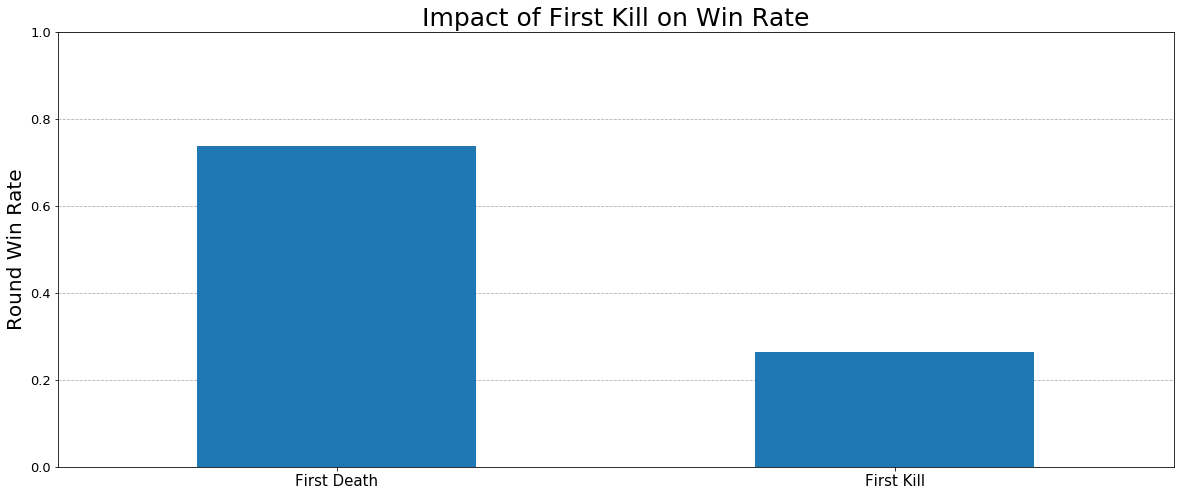

In [6]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
ax = dfWinRate.plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2)

# Add labels and titles
ax.set_title("Impact of First Kill on Win Rate", fontsize=25)
ax.set_ylabel("Round Win Rate", fontsize = 20)
ax.set_xticklabels(["First Death", "First Kill"], fontsize=15)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=0)

# Set ylim 
ax.set_ylim(0,1)

# Add gridlines
ax.grid(axis="y", linestyle="--")

# Remove unnecessary legend
ax.get_legend().remove()

As we can see, the impact of the first kill on the win rate of a round is substantial. Teams that drew first blood secured the round nearly three quarters of the time. Although I predicted it would be a heavy factor in the round, I did not realise just how big.

## Difference in Win Rate by Side

Next I want to look at if this impact is affected by which side claims the first kill, counter-terrorist or terrorist. 
To do this, I will calculate the win rates of two different DataFrames, one that contains only CT first kills and one that contains only T first kills. These will be passed into a predefined function that was used previously.

In [7]:
# Get CT winrate
dfCTWinRate = get_round_win_rate(dfFirstKills[dfFirstKills["Side"] == "ct"])

# Rename column
dfCTWinRate = dfCTWinRate.rename(index=str, columns={"Won Round": "CT Win Rate"})
dfCTWinRate

,CT Win Rate
True,0.74081
False,0.25919


In [8]:
# Get CT winrate
dfTWinRate = get_round_win_rate(dfFirstKills[dfFirstKills["Side"] == "terrorist"])

# Rename column
dfTWinRate = dfTWinRate.rename(index=str, columns={"Won Round": "T Win Rate"})
dfTWinRate

,T Win Rate
True,0.732193
False,0.267807


Concatenate DataFrames so that only one needs to be used for the bar chart.

In [9]:
dfWinRateBySide = pd.concat([dfCTWinRate, dfTWinRate], axis=1, join_axes=[dfCTWinRate.index])
dfWinRateBySide

,CT Win Rate,T Win Rate
True,0.74081,0.732193
False,0.25919,0.267807


Plot the bar chart using matplotlib. This time, the chart will show the difference between CT and Terrorist win rates, distinguishing them by colour.

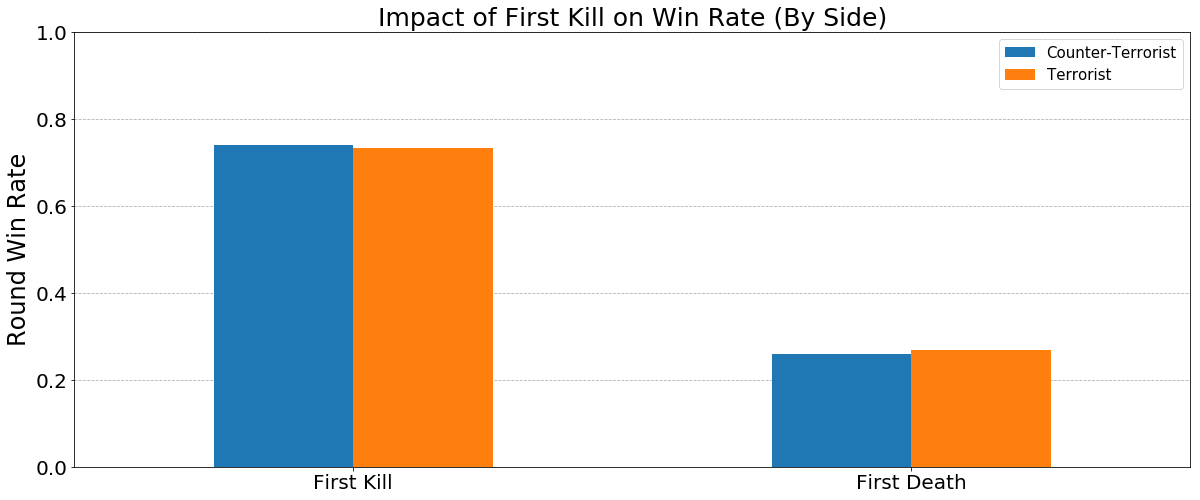

In [10]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
ax = dfWinRateBySide.plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2)

# Add labels and titles
ax.set_title("Impact of First Kill on Win Rate (By Side)", fontsize=25)
ax.set_ylabel("Round Win Rate", fontsize = 24)
ax.set_xticklabels(["First Kill", "First Death"], fontsize=15)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=0, labelsize=20)

# Set ylim 
ax.set_ylim(0,1)

# Add gridlines
ax.grid(axis="y", linestyle="--")

# Add legend
ax.legend(["Counter-Terrorist", "Terrorist"], fontsize=15)

As it turns out, this impact does not really change depending on if you are defending or attacking. In this graph, blue represents the Counter-Terrorists (defensive side) and orange represents the Terrorists (attacking side). There is only a slight difference between the two, but nothing of note.

## Does Time to First Kill Have Any Correlation to Win Rate?
One of the interesting statistics provided by DreamTeam is the time to first kill. Before undertaking this analysis I predicted that a faster first kill correlated to a higher win rate.

To do this, I will plot a regplot using Seaborn. First I need to bin the time values.

In [11]:
dfTimeCount = dfFirstKills.groupby("Time (Seconds)")[["Won Round"]].count()
dfTimeCount

,Won Round
Time (Seconds),
-105,1
-29,1
3,16
4,16
5,16
6,10
7,18
8,74
9,113


Calculate the average win rate for each time included in the dataset.

In [12]:
dfTimeMean = dfFirstKills.groupby("Time (Seconds)")[["Won Round"]].mean()
dfTimeMean

,Won Round
Time (Seconds),
-105,0.000000
-29,0.000000
3,0.687500
4,0.812500
5,0.875000
6,0.800000
7,0.500000
8,0.675676
9,0.787611


Concatenate the two DataFrames and rename the columns.

In [13]:
dfTime = pd.concat([dfTimeCount, dfTimeMean], axis=1)
dfTime.columns = ["Count", "Mean"]
dfTime

,Count,Mean
Time (Seconds),,
-105,1,0.000000
-29,1,0.000000
3,16,0.687500
4,16,0.812500
5,16,0.875000
6,10,0.800000
7,18,0.500000
8,74,0.675676
9,113,0.787611


Only include times that have more than 10 occurences. Move the "Time (Seconds") column from the index to an actual column. This makes it easier to plot.

In [14]:
dfTimeScatter = dfTime[dfTime["Count"] > 10]
dfTimeScatter = dfTimeScatter.reset_index(level=["Time (Seconds)"])
dfTimeScatter

,Time (Seconds),Count,Mean
0,3,16,0.687500
1,4,16,0.812500
2,5,16,0.875000
3,7,18,0.500000
4,8,74,0.675676
5,9,113,0.787611
6,10,129,0.767442
7,11,177,0.807910
8,12,252,0.654762
9,13,256,0.707031


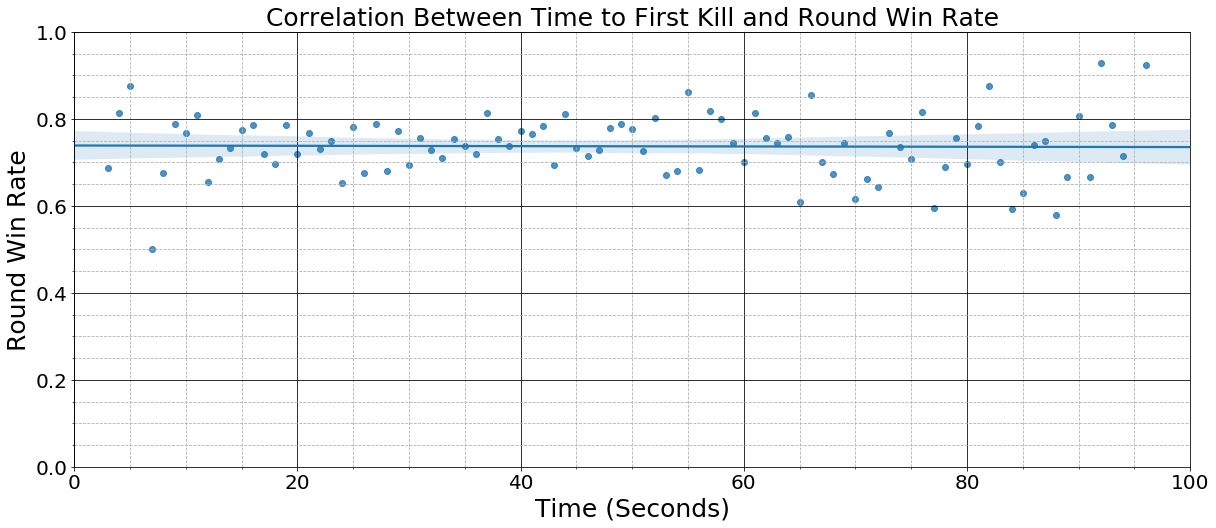

In [15]:
# Plot scatterplot using seaborn
ax = plt.subplots(figsize=(20,8))
ax = sns.regplot(x="Time (Seconds)", y="Mean", data=dfTimeScatter)

# Add labels and titles
ax.set_title("Correlation Between Time to First Kill and Round Win Rate", fontsize=25)
ax.set_ylabel("Round Win Rate", fontsize = 25)
ax.set_xlabel("Time (Seconds)", fontsize = 25)

# Set axes limits and parameters
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.tick_params(labelsize=20)

# Add gridlines
ax.minorticks_on()
ax.grid(which="minor", zorder=-2, linestyle="--")
ax.grid(which="major", color="black", zorder=-1, linestyle="-")

To my surprise (and slight disappointment), there seemed to be absolutely no correlation between time to first kill and round win rate. The line of best fit is an almost perfectly straight line across the graph. This completely contradicted my prediction and was something that I personally found interesting.


A histogram is then formed to show the most frequen time to first kill.

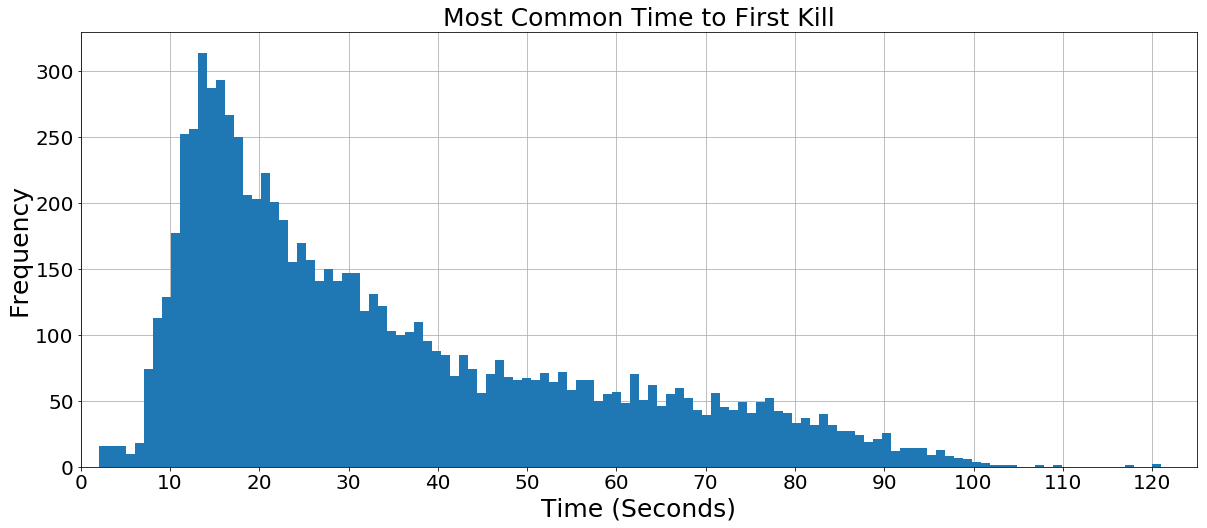

In [16]:
figure, ax = plt.subplots(figsize=(20,8))

# Plot histogram with zorder 2 to be ahead of gridlines
ax.hist(dfFirstKills["Time (Seconds)"], bins = 120, range=(0,121), zorder=3)

# Add labels and titles
ax.set_title("Most Common Time to First Kill", fontsize=25)
ax.set_ylabel("Frequency", fontsize = 25)
ax.set_xlabel("Time (Seconds)", fontsize = 25)

# Set axes limits and parameters
ax.set_xlim(0,125)
ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100,110,120])
ax.tick_params(labelsize=20)

# Add gridlines
ax.grid(axis="y", linestyle="-")
ax.grid(axis="x", linestyle="-")

As we can see, the 10-20 second interval is where the majority of the first kills are obtained.

## Does the Map Have Any Impact?
After time showed not affect, I wanted to look at how the the round win rate after the first kill was impacted by the map the matchw as being played on.

In [17]:
# Group DataFrame by map and calculate averages
dfFKByMap = dfFirstKills.groupby("Map").mean()

# Drop unnecessary columns
dfFKByMap = dfFKByMap.drop(["Match ID", "Round"], axis=1)
dfFKByMap

,Time (Seconds),Won Round
Map,,
Cache,33.960993,0.743794
Cobblestone,36.783153,0.747289
Dust2,31.740385,0.715237
Inferno,39.241142,0.749016
Mirage,30.898400,0.725600
Nuke,33.989601,0.731369
Overpass,38.796260,0.753937
Train,36.201149,0.735632


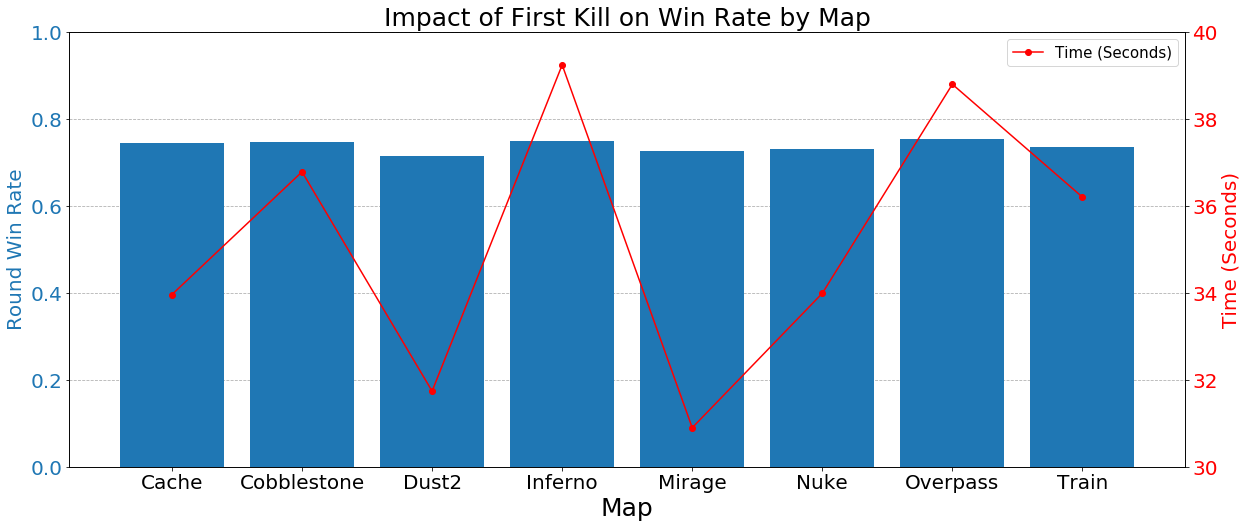

In [18]:
# Plotting two graphs on one figure, so use subplots
fig, ax1 = plt.subplots(figsize=(20,8))

# Plot bar chart of maps and their round win rate, zorder 2 to be ahead of gridlines, but behind line graph
ax1.bar(dfFKByMap.index, dfFKByMap["Won Round"], zorder=2)

# Add labels and titles
ax1.set_title("Impact of First Kill on Win Rate by Map", fontsize=25)
ax1.set_xlabel("Map", fontsize=25)
ax1.set_ylabel("Round Win Rate", color="C0", fontsize=20)

# Set axes limits and parameters
ax1.set_ylim(0,1)
ax1.tick_params(labelsize=20)
ax1.tick_params(axis="y", labelcolor="C0")

# Add gridlines
ax1.grid(axis="y", linestyle="--")
ax1.grid(axis="x", linestyle=" ")

# Set second subplot to share x axis of first one
ax2 = ax1.twinx()

# Plot line graph of time to first kill for each map
ax2.plot(dfFKByMap.index, dfFKByMap["Time (Seconds)"], color="r", marker="o", zorder=3)

# Add labels
ax2.set_ylabel("Time (Seconds)", color="r", fontsize=20)

# Set axes limits and parameters
ax2.set_ylim(30,40)
ax2.tick_params(labelsize=20)
ax2.tick_params(axis="y", labelcolor="r")

# Add legend
ax2.legend(fontsize=15)

The graph shows that there is little variation in win rate by map. The first kill is of huge importance no matter what the playing field is, with the only variation being shown in the time to first kill. We see that Mirage has the quickest first kill at around 31 seconds, while Inferno has the slowest at approximately 39 seconds. 

## Teams Best and Worst at Converting the Advantage
Having shown how impactful the first kill is on the outcome of a round, I would like to see which teams are the best and which are the worst at taking advantage of the first kill.

In [19]:
dfFKBaW = get_best_and_worst(dfFirstKills)
dfFKBaW

,Won Round,Round
Team,,
London Conspiracy,0.285714,14
MTS GameGod Wolf,0.333333,18
Splyce,0.411765,17
Vitality,0.777778,18
LGB eSports,0.837838,37
Immortals,0.879121,91


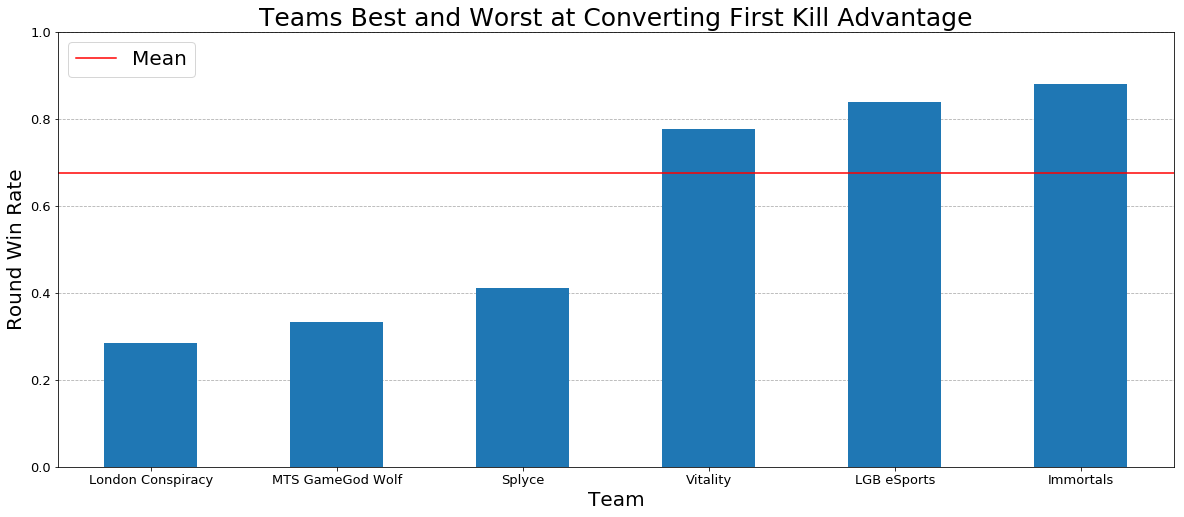

In [20]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
ax = dfFKBaW["Won Round"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value
ax.axhline(y=get_team_mean(dfFirstKills), color="r", label="Mean")

# Add labels and titles
ax.set_title("Teams Best and Worst at Converting First Kill Advantage", fontsize=25)
ax.set_ylabel("Round Win Rate", fontsize = 20)
ax.set_xlabel("Team", fontsize = 20)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=0)

# Set ylim 
ax.set_ylim(0,1)

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(loc="upper left", fontsize=20)

## Most and Least Successful First Killers
After looking at the teams, I wanted to look at first kills on a player level. Using the percentage of kills that are first kills metric in my HLTV player dataset, I will plot a bar chart of the 3 most and least successful players at obtaining the first kill.

Using a predefined function, I will find the the players needed and the mean value for all players.

In [21]:
dfFKPlayersBaW, meanFK = get_player_baw(dfPlayerStats, "FK%K")
dfFKPlayersBaW

,Rounds,FK%K
Player,,
Xyp9x,99,9.016168
coldzera,72,9.307475
Happy,62,10.511798
pashaBiceps,80,18.683445
JW,97,18.989965
FalleN,78,19.234511


In [22]:
meanFK

14.739176223678719

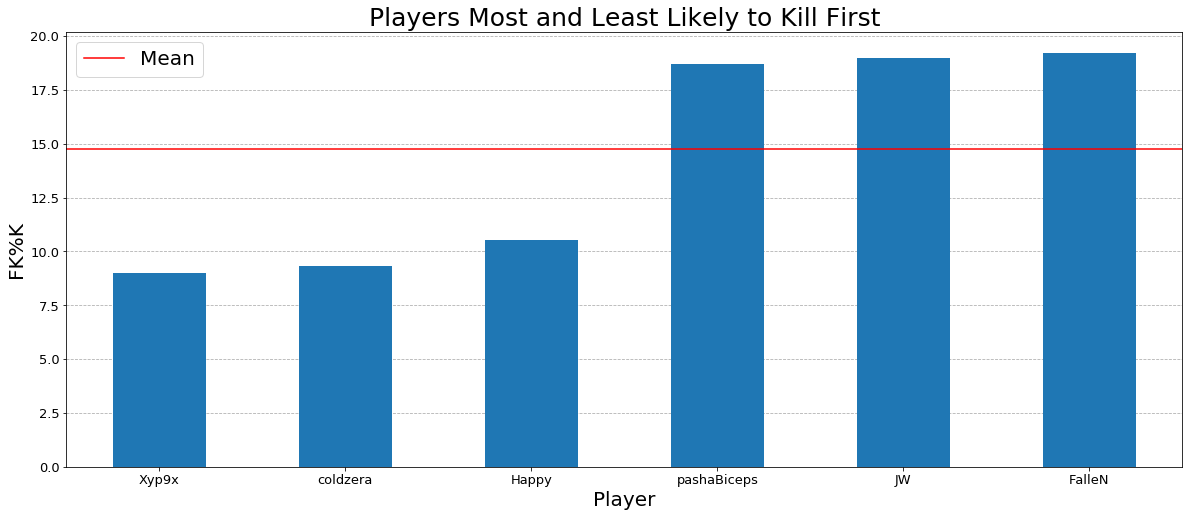

In [23]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
# _nolegend_ removes the bars from the legend
ax = dfFKPlayersBaW["FK%K"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value
ax.axhline(y=meanFK, color="r", label="Mean")

# Add labels and titles
ax.set_title("Players Most and Least Likely to Kill First", fontsize=25)
ax.set_ylabel("FK%K", fontsize = 20)
ax.set_xlabel("Player", fontsize = 20)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=0)

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(loc="upper left", fontsize = 20)

The first thing to notice is that the top 3 players are all awpers (the dedicated snipers on the team). This is the first indication that awpers are proficient first killers, something that will be highlighted later on.

As for the bottom three, Xyp9x (pronounced zip-icks) is renowned for his support play (assisting his teammates by using utility or his positioning to put them in a position to kill), so it's no suprise he isn't highly ranked in this regard. Happy is usually a lurker, someone who stays away from the rest of his team and tries to flank and cause distraction. Again this explains why he wouldn't be engaged in intial battles. Coldzera has twice been [HLTV Player of the Year](https://liquipedia.net/counterstrike/HLTV/Top_20_Players), so I just found it interesting that he was the second worst at getting the first kill.

## Most and Least Likely to Die First
On the opposite side of the coin, I now want to look at the players who's deaths as a percantage of their deaths is high and low. Using the same predefined function (with a different second parameter), I will again find the three most and least likely players and the overall average.

In [24]:
dfFDPlayersBaW, meanFD = get_player_baw(dfPlayerStats, "FD%D")
dfFDPlayersBaW

,Rounds,FD%D
Player,,
Happy,62,8.873433
Xyp9x,99,11.252543
coldzera,72,11.479823
JW,97,18.340049
rain,67,18.622317
SmithZz,54,19.449728


In [25]:
meanFD

14.85379700302437

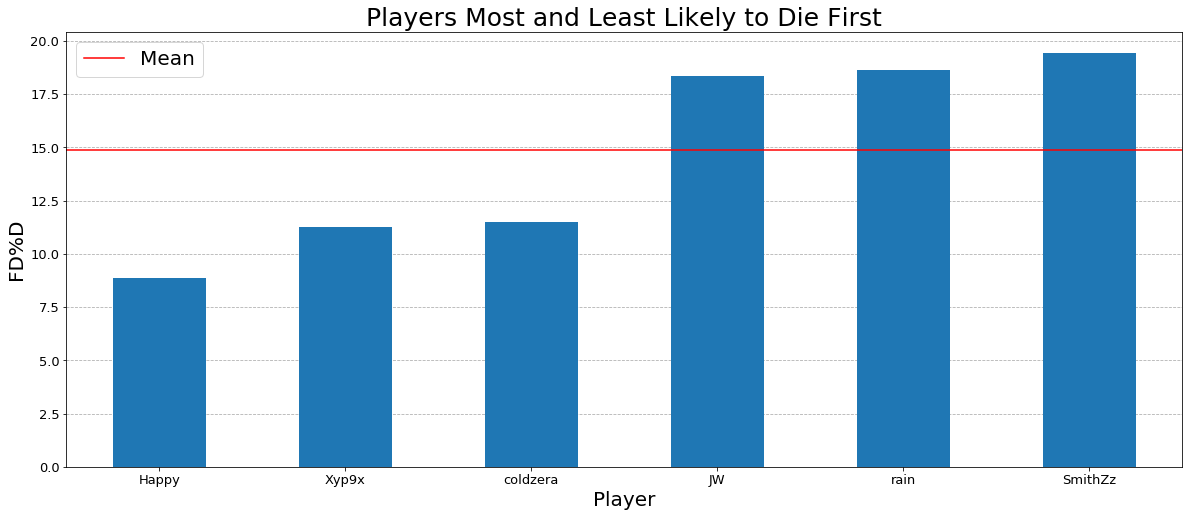

In [26]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
# _nolegend_ removes the bars from the legend
ax = dfFDPlayersBaW["FD%D"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value
ax.axhline(y=meanFD, color="r", label="Mean")

# Add labels and titles
ax.set_title("Players Most and Least Likely to Die First", fontsize=25)
ax.set_ylabel("FD%D", fontsize = 20)
ax.set_xlabel("Player", fontsize = 20)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=0)

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(loc="upper left", fontsize = 20)

JW remains in the top three for this metric as well, he is also the only awper out of all 6 players listed. He is well known to be an aggressive awper, attempting to push early in the round in hope of taking the advantage. This would explain his high ranking in both graphs. SmithZz was a former awper, however he does not appear in the top three of the previous graph.

In [27]:
# Calculate the FK%K for SmithZz
dfPlayerStats.groupby("Player")[["FK%K"]].mean()[dfPlayerStats.groupby("Player")[["FK%K"]].mean().index == "SmithZz"]

,FK%K
Player,
SmithZz,17.820948


As we can see, his FK%K is above average (14.74%), but his FD%D is nearly 5% above the mean. This could be a factor in his decision to step away from the AWP full time instead choosing to use a rifle.

However, the most interesting aspect of this graph is that the bottom three players remain the same. Coldzera, Xyp9x, and Happy all appear again which shows just how far away from the intial duels these players are. Looking at players who are under the mean for both FK%K and FD%D could be used in future work as a metric for a classification model, but I would need more information and research into different factors.

## Weapons Used
The DreamTeam analysis tool also gives information on the weapons used by both players involved in the first kill. I thought it would be interesting to see how the weapons compare.

In [28]:
dfWeaponUsed = dfFirstKills.groupby("Weapon Used").count()
dfWeaponUsed = dfWeaponUsed.sort_values(by=["Player"])

# Only one column is necessary
dfWeaponUsed = dfWeaponUsed[["Round"]]
dfWeaponUsed

,Round
Weapon Used,
taser,1
knife,2
bizon,2
g3sg1,3
sawedoff,4
xm1014,4
nova,6
aug,8
scar20,27


In [29]:
dfVictimWeapon = dfFirstKills.groupby("Victim Weapon").count()
dfVictimWeapon = dfVictimWeapon.sort_values(by=["Player"])

# Only one column is necessary
dfVictimWeapon = dfVictimWeapon[["Player"]]
dfVictimWeapon

,Player
Victim Weapon,
bizon,1
elite,1
taser,2
c4,2
sg556,2
xm1014,3
sawedoff,5
scar20,7
nova,9


Concatenate the two DataFrames, comparing the first kills to the first deaths. Certain weapon names are also renamed so that they are shorter and therefore easier to fit on the graph. The the **m4a1** becomes the **m4a4** (in the game files it is referred to as the m4a1, however in game it is known as the m4a4), the **m4a1_silencer** becomes the **m4a1**, and the **usp_silencer** becomes the **usp**.

In [30]:
dfWeapons = pd.concat([dfWeaponUsed, dfVictimWeapon], axis=1, sort=True)
dfWeapons = dfWeapons.sort_values(by=["Round"], ascending=False)

# Rename certain weapons
dfWeapons = dfWeapons.rename(index={"m4a1": "m4a4", "m4a1_silencer": "m4a1", "usp_silencer": "usp"})

dfWeapons

,Round,Player
ak47,2433.0,1920.0
awp,1545.0,365.0
m4a1,1081.0,155.0
m4a4,826.0,838.0
usp,310.0,186.0
glock,240.0,484.0
cz75a,239.0,92.0
famas,200.0,128.0
p250,180.0,749.0
deagle,172.0,271.0


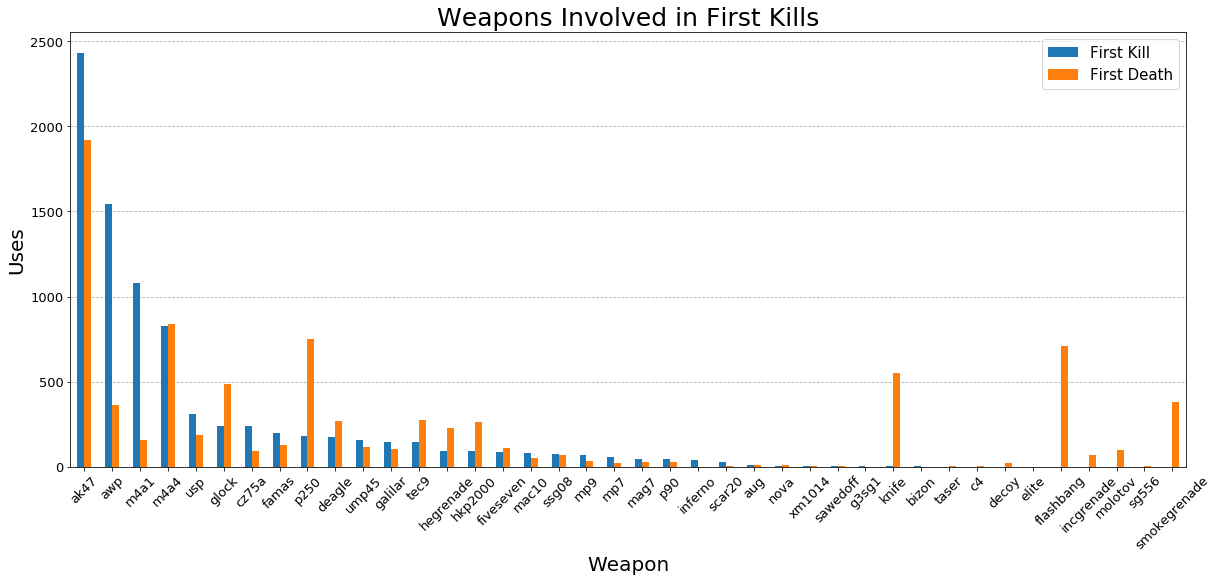

In [31]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
ax = dfWeapons.plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2)

# Add labels, titles
ax.set_title("Weapons Involved in First Kills", fontsize=25)
ax.set_ylabel("Uses", fontsize = 20)
ax.set_xlabel("Weapon", fontsize = 20)

# Rotate tick labels so they're easily legible
ax.tick_params(axis="x", bottom=True, rotation=45)


# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(["First Kill", "First Death"], fontsize=15)

This graph shows just how popular the AK47 is in game. A weapon that only the Terrorist side can buy, it is superior assault rifle in terms of damage. The dominance of a rifle that is exclusively bought by one side over the M4A4 and the M4A1 (the Counter-Terrorist assault rifles) can be explained by the fact that when dropped by Terrorists, a Counter-Terrorist will almost certainly pick it up and use it until they are killed.

Again, we see the impact of the AWP during the intial duel. This graph shows just how effective it can be at opening up the round in a team's favour, with over 1500 first kills compared to less than 500 first deaths.

## Using First Kills and First Deaths to Rate an Awper
As shown in the graph above, the AWP has more than three times the amount of first kills to first deaths. Using this statistic, I wanted to see how different awpers (the member of a team who is the dedicated sniper) compare.

For this analysis I will use the HLTV dataset scraped at the beginning.

A list of awpers is taken from HLTV to filter the dataset.

In [32]:
awpers = ["FalleN", "oskar", "Skadoodle", "kennyS", "s1mple", "JW", "Jame", "device", "GuardiaN", "draken", "jdm64", "woxic", "ZywOo", "smooya", "allu", "mixwell", "WorldEdit", "markeloff", "xccurate", "pashaBiceps"]

This list is then used in a mask to only keep this list of players.

In [33]:
dfAwpers = dfPlayerStats[dfPlayerStats["Player"].isin(awpers)]
dfAwpers

,Match ID,Event,Date,Player,Team,Map,Rounds,Kills,Deaths,FK,FD,FK%K,FD%D,Rating
2,82145,IEM Katowice 2019,2019-03-03 18:05:00,allu,ENCE,Inferno,20,7,17,0,0,0.000000,0.000000,0.49
5,82145,IEM Katowice 2019,2019-03-03 18:05:00,device,Astralis,Inferno,20,22,8,3,0,13.636364,0.000000,1.89
11,82143,IEM Katowice 2019,2019-03-03 18:05:00,allu,ENCE,Train,27,20,21,6,1,30.000000,4.761905,1.04
18,82143,IEM Katowice 2019,2019-03-03 18:05:00,device,Astralis,Train,27,21,15,2,1,9.523810,6.666667,1.14
23,82123,IEM Katowice 2019,2019-03-02 19:20:00,FalleN,MIBR,Inferno,23,13,16,0,2,0.000000,12.500000,0.86
28,82123,IEM Katowice 2019,2019-03-02 19:20:00,device,Astralis,Inferno,23,14,14,2,2,14.285714,14.285714,1.16
33,82121,IEM Katowice 2019,2019-03-02 19:20:00,FalleN,MIBR,Overpass,30,16,20,2,2,12.500000,10.000000,0.92
38,82121,IEM Katowice 2019,2019-03-02 19:20:00,device,Astralis,Overpass,30,17,18,1,3,5.882353,16.666667,0.96
40,82120,IEM Katowice 2019,2019-03-02 15:10:00,s1mple,Natus Vincere,Mirage,30,32,19,4,1,12.500000,5.263158,1.51
49,82120,IEM Katowice 2019,2019-03-02 15:10:00,allu,ENCE,Mirage,30,13,21,2,3,15.384615,14.285714,0.64


Calculate the difference between perecentage of kills that were first kills and percentage of deaths that were first deaths.

In [34]:
dfAwpers = dfAwpers.assign(FKFD_Diff = dfAwpers["FK%K"] - dfAwpers["FD%D"])
dfAwpers

,Match ID,Event,Date,Player,Team,Map,Rounds,Kills,Deaths,FK,FD,FK%K,FD%D,Rating,FKFD_Diff
2,82145,IEM Katowice 2019,2019-03-03 18:05:00,allu,ENCE,Inferno,20,7,17,0,0,0.000000,0.000000,0.49,0.000000
5,82145,IEM Katowice 2019,2019-03-03 18:05:00,device,Astralis,Inferno,20,22,8,3,0,13.636364,0.000000,1.89,13.636364
11,82143,IEM Katowice 2019,2019-03-03 18:05:00,allu,ENCE,Train,27,20,21,6,1,30.000000,4.761905,1.04,25.238095
18,82143,IEM Katowice 2019,2019-03-03 18:05:00,device,Astralis,Train,27,21,15,2,1,9.523810,6.666667,1.14,2.857143
23,82123,IEM Katowice 2019,2019-03-02 19:20:00,FalleN,MIBR,Inferno,23,13,16,0,2,0.000000,12.500000,0.86,-12.500000
28,82123,IEM Katowice 2019,2019-03-02 19:20:00,device,Astralis,Inferno,23,14,14,2,2,14.285714,14.285714,1.16,0.000000
33,82121,IEM Katowice 2019,2019-03-02 19:20:00,FalleN,MIBR,Overpass,30,16,20,2,2,12.500000,10.000000,0.92,2.500000
38,82121,IEM Katowice 2019,2019-03-02 19:20:00,device,Astralis,Overpass,30,17,18,1,3,5.882353,16.666667,0.96,-10.784314
40,82120,IEM Katowice 2019,2019-03-02 15:10:00,s1mple,Natus Vincere,Mirage,30,32,19,4,1,12.500000,5.263158,1.51,7.236842
49,82120,IEM Katowice 2019,2019-03-02 15:10:00,allu,ENCE,Mirage,30,13,21,2,3,15.384615,14.285714,0.64,1.098901


Plot a regplot to see if there is a correlation between the FK%K-FD%D Difference metric and the HTLV rating.

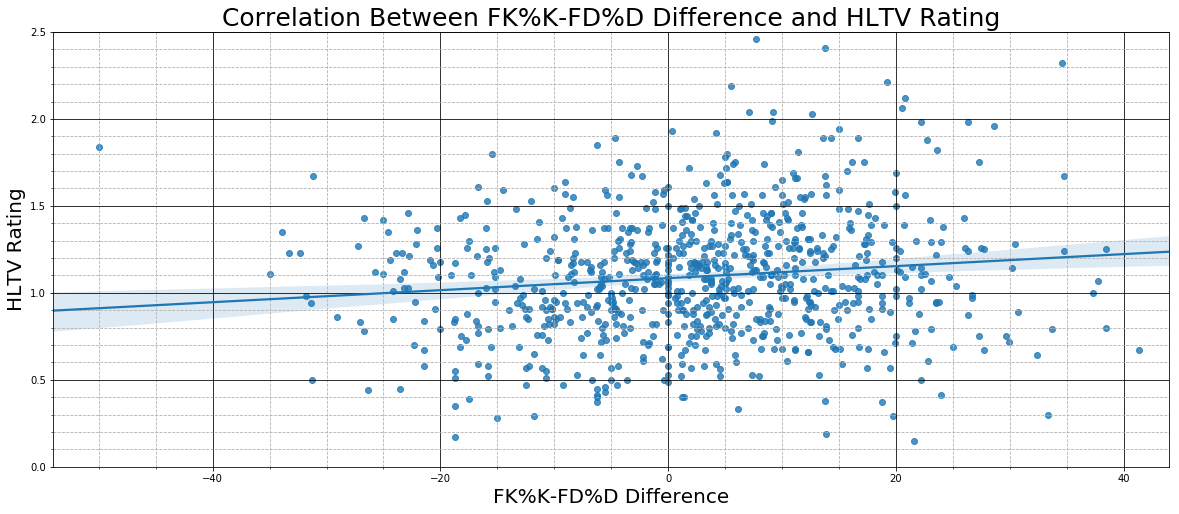

In [35]:
# Plot scatterplot using seaborn
ax = plt.subplots(figsize=(20,8))
ax = sns.regplot(x="FKFD_Diff", y="Rating", data=dfAwpers)

# Add labels and titles
ax.set_title("Correlation Between FK%K-FD%D Difference and HLTV Rating", fontsize=25)
ax.set_ylabel("HLTV Rating", fontsize = 20)
ax.set_xlabel("FK%K-FD%D Difference", fontsize = 20)

# Set limits
ax.set_ylim(0, 2.5)
ax.set_xlim(-54, 44)

# Add gridlines
ax.minorticks_on()
ax.grid(which="minor", zorder=-2, linestyle="--")
ax.grid(which="major", color="black", zorder=-1, linestyle="-")

The graph shows a slight positive correlation between FK%K-FD%D Difference and HLTV's rating. I will now use this metric to rank the selected awpers.

Find the average FK%K-FD%D Difference for each awper, only keeping players who have played in more than 10 matches.

In [36]:
# Find mean
dfAwperMean = dfAwpers.groupby("Player")[["FKFD_Diff"]].mean()

# Find matches
dfAwperCount = dfAwpers.groupby("Player")[["Rounds"]].count()

# Merge
dfAwperRanking = pd.merge(dfAwperMean, dfAwperCount, on=["Player"])

# Drop players with 10 or less games
dfAwperRanking = dfAwperRanking[dfAwperRanking["Rounds"]>10]

# Sort
dfAwperRanking = dfAwperRanking.sort_values("FKFD_Diff")
dfAwperRanking

,FKFD_Diff,Rounds
Player,,
jdm64,-1.300220,35
woxic,-0.330280,15
markeloff,0.636866,42
JW,0.649916,97
device,1.456203,99
kennyS,2.238124,63
GuardiaN,2.611147,88
pashaBiceps,3.164401,80
s1mple,3.573645,60


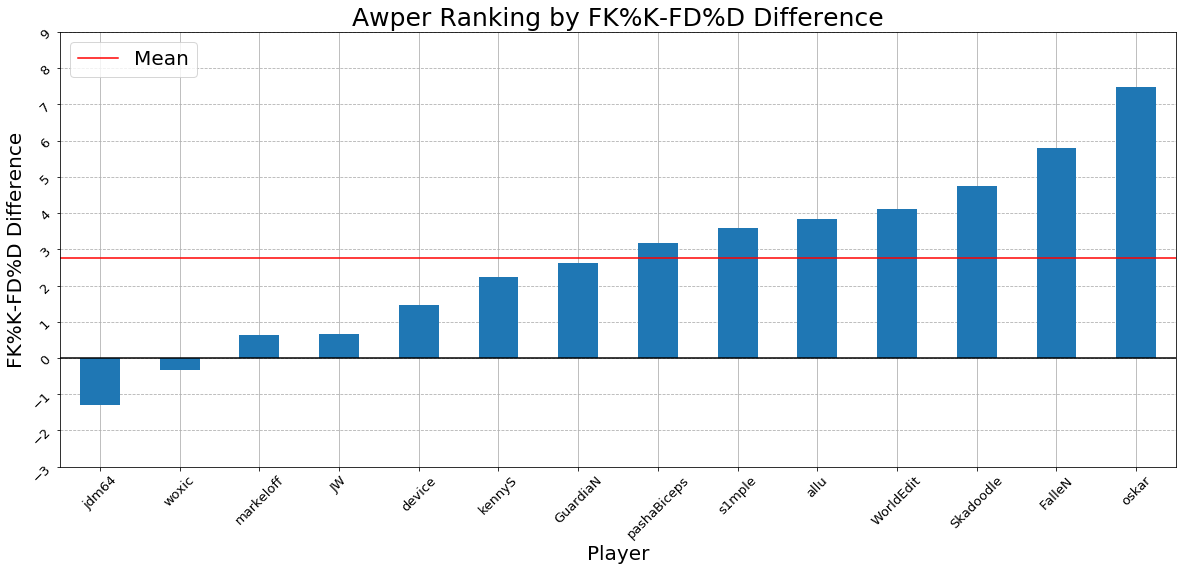

In [37]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
# _nolegend_ removes the bars from the legend
ax = dfAwperRanking["FKFD_Diff"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value and a black line for the y-axis 0 value
ax.axhline(y=dfAwperRanking["FKFD_Diff"].mean(), color="r", label="Mean")
ax.axhline(y=0, color="black")

# Add labels and titles
ax.set_title("Awper Ranking by FK%K-FD%D Difference", fontsize=25)
ax.set_ylabel("FK%K-FD%D Difference", fontsize = 20)
ax.set_xlabel("Player", fontsize = 20)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=45)
ax.set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7,8,9])

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle="-")

# Add legend
ax.legend(loc="upper left", fontsize = 20)

## With Regards to the First Kill, Which Maps do Awpers Have the Most Impact?
Again using the difference between percentage of kills that were first kills and percentage of deaths that were first deaths, I want to look at which maps awpers have the most impact.

The awper DataFrame is grouped by map and the mean of the difference column is found.

In [38]:
dfAwpMap = dfAwpers.groupby("Map")[["FKFD_Diff"]].mean()

# Sort
dfAwpMap = dfAwpMap.sort_values("FKFD_Diff")
dfAwpMap

,FKFD_Diff
Map,
Inferno,1.440704
Mirage,1.962069
Cobblestone,2.098608
Train,2.523094
Overpass,2.725656
Cache,3.421093
Nuke,3.955534
Dust2,4.555642


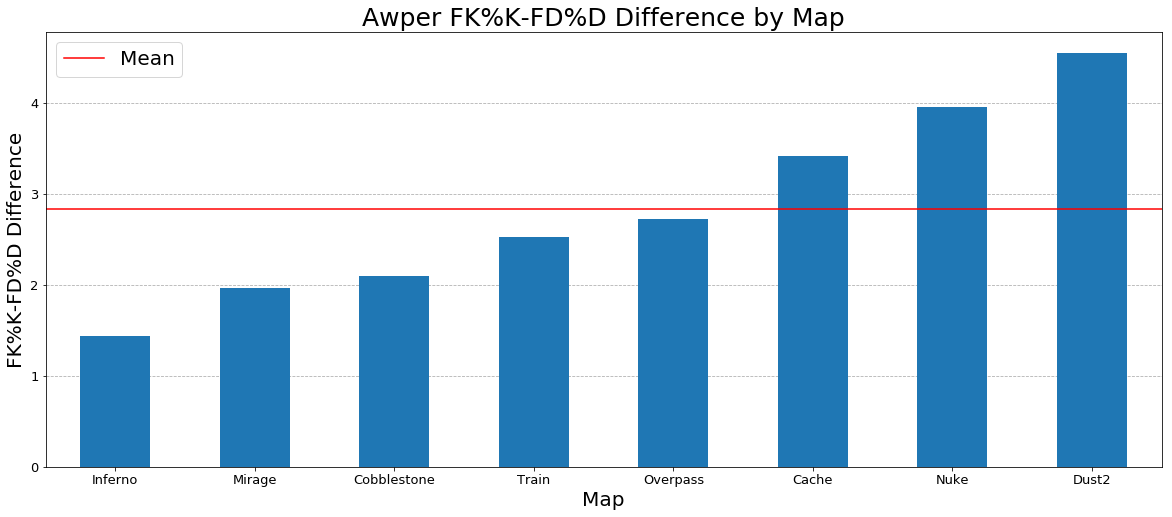

In [39]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
# _nolegend_ removes the bars from the legend
ax = dfAwpMap["FKFD_Diff"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value
ax.axhline(y=dfAwpMap["FKFD_Diff"].mean(), color="r", label="Mean")

# Add labels and titles
ax.set_title("Awper FK%K-FD%D Difference by Map", fontsize=25)
ax.set_ylabel("FK%K-FD%D Difference", fontsize = 20)
ax.set_xlabel("Map", fontsize = 20)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=0)


# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(loc="upper left", fontsize = 20)

From the graph it is clear to see that Dust2 and Nuke are where an awper can have the greatest impact by this metric, with Inferno having the lowest score. This would lead me to believe that Dust2 is the safest map for awpers to play aggressively and go for the first kill, whereas Inferno is the opposite.